In [1]:
!pip install skl2onnx
!pip install onnxruntime
!pip install xgboost
!pip install onnxmltools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.5/352.5 kB 5.5 MB/s eta 0:00:00


In [6]:
from pathlib import Path
from IPython.display import display
import hashlib, datetime, glob, os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from tqdm.auto import tqdm
from sklearn.ensemble import IsolationForest
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as ort
import onnxmltools
from xgboost import XGBRegressor


In [7]:
data_dir = Path('/content/drive/MyDrive/TAQA/clean')
meta_dir = Path('/content/drive/MyDrive/TAQA/clean/meta')
parquet = data_dir / 'wide_tools_flat.parquet'
scalers_js = data_dir / 'meta' / 'scalers.json'
models_dir = Path('wwwroot/models')

df = pd.read_parquet(parquet)
with open(scalers_js, 'r') as f:
  scalers= json.load(f)

In [8]:
print(f'Parquet loaded {parquet}')
print(f'shape: {df.shape[0]:,} rows X {df.shape[1]} columns') # :, is to tell pyton formatting output with , (171,152)
print(f' sample keys: {list(scalers)}')

Parquet loaded /content/drive/MyDrive/TAQA/clean/wide_tools_flat.parquet
shape: 171,659 rows X 7 columns
 sample keys: ['P8-1', 'P8-38', 'P8-41', 'P8-59', 'P8-7']


In [9]:
#Stage 2 choke position thresold and cleaning up table
CHOKE_OPEN_THRESHOLD = 10.0

# Flatten the MultiIndex -----------------------------------------------
df_flat = (
    df                   # your existing MultiIndex DF (Tool, Timestamp)
    .reset_index()       # becomes regular columns: Tool, Timestamp, …
    .rename(columns={"Tool": "ToolId"})  # shorter, avoids clash with pandas .tool
)

# 2⃣  Make sure Timestamp is timezone-aware datetime -----------------------
df_flat["Timestamp"] = pd.to_datetime(df_flat["Timestamp"], utc=True)

# 3⃣  Add IsOpen flag based on Choke-Position ------------------------------
df_flat["IsOpen"] = (df_flat["Choke-Position"] > CHOKE_OPEN_THRESHOLD).astype(int)

df_flat["DeltaTemperature"]  = (
    df_flat["Upstream-Temperature"] - df_flat["Downstream-Temperature"]
)

# 5⃣  Quick sanity check ----------------------------------------------------
print("✅ DataFrame ready for training")
print(f"   rows:        {len(df_flat):,}")
print(f"   columns:     {df_flat.columns.tolist()}")
print(f"   tools seen:  {df_flat['ToolId'].nunique()} → {df_flat['ToolId'].unique()[:10]}…")

display(df_flat.head())


✅ DataFrame ready for training
   rows:        171,659
   columns:     ['ToolId', 'Timestamp', 'Choke-Position', 'Upstream-Pressure', 'Upstream-Temperature', 'Downstream-Upstream-Difference', 'Battery-Voltage', 'Downstream-Pressure', 'Downstream-Temperature', 'IsOpen', 'DeltaPressure', 'DeltaTemperature']
   tools seen:  5 → ['P8-1' 'P8-38' 'P8-41' 'P8-59' 'P8-7']…


param,ToolId,Timestamp,Choke-Position,Upstream-Pressure,Upstream-Temperature,Downstream-Upstream-Difference,Battery-Voltage,Downstream-Pressure,Downstream-Temperature,IsOpen,DeltaPressure,DeltaTemperature
0,P8-1,2025-02-17 09:12:50+00:00,100.11760,19.429405,14.204285,-4.060623,14.14728,15.368665,14.124375,1,4.060740,0.079910
1,P8-1,2025-02-17 09:13:00+00:00,100.12635,19.148040,14.204865,-3.778663,14.14728,15.369375,14.124850,1,3.778665,0.080015
2,P8-1,2025-02-17 09:13:10+00:00,100.10810,19.134050,14.205900,-3.765228,14.14728,15.368740,14.125760,1,3.765310,0.080140
3,P8-1,2025-02-17 09:13:20+00:00,100.13510,19.143310,14.206670,-3.775223,14.14728,15.368710,14.126560,1,3.774600,0.080110
4,P8-1,2025-02-17 09:13:30+00:00,100.13510,19.151140,14.207980,-3.771896,14.15137,15.379240,14.127590,1,3.771900,0.080390


In [12]:
#Stage 3 - Train IF on Chokeposition
onnx_file = models_dir / 'choke_position.onnx'
feature_name = 'Choke-Position'

X = df_flat[[feature_name]].dropna().astype(np.float32).values
print(f'Training rows used: {X.shape[0]:,}')

if_model = IsolationForest(n_estimators =200, contamination = 0.05, random_state=42).fit(X)
print(f"✅ Model trained")

initial_type = [('input', FloatTensorType([None,1]))]
target_opsets = {'':12, 'ai.onnx.ml':3}
onnx_model = convert_sklearn(if_model, initial_types = initial_type, target_opset= target_opsets)
onnx_file.parent.mkdir(parents=True, exist_ok=True)
with open(onnx_file, 'wb') as f:
  f.write(onnx_model.SerializeToString())

print(f'ONNX model saved to: {onnx_file.resolve()}')

#smoke test
sess   = ort.InferenceSession(onnx_file.as_posix(), providers=["CPUExecutionProvider"])
score  = sess.run(None, {"input": X[:5]})[0]      # anomaly scores for first 5 rows
print("Sample scores:", np.round(score.flatten(), 4))


Training rows used: 171,647
✅ Model trained
ONNX model saved to: /content/wwwroot/models/choke_position.onnx
Sample scores: [1 1 1 1 1]


In [13]:
out_names = [o.name for o in sess.get_outputs()]
print("ONNX outputs:", out_names)

labels, scores = sess.run(None, {"input": X[:5]})
print("Labels :", labels.flatten())     # 1 = inlier, -1 = anomaly
print("Scores :", np.round(scores, 4))  # higher → more anomalous

ONNX outputs: ['label', 'scores']
Labels : [1 1 1 1 1]
Scores : [[0.1199]
 [0.1185]
 [0.1259]
 [0.114 ]
 [0.114 ]]


In [14]:
#stage 4 - Trian 2D IF on pressure data
pres_features= ["Upstream-Pressure", "Downstream-Pressure"]
onnx_open_pressure = models_dir / 'pressure_pair_open.onnx'
onnx_shut_pressure = models_dir / 'pressure_pair_shut.onnx'
target_opsets = {'':12, 'ai.onnx.ml':3}
min_rows = 500

def train_if(df_subset, feat_columns, onnx_path, tag):
  X= df_subset[feat_columns].dropna().astype(np.float32).values
  if len(X) < min_rows:
    print(f'{tag}: only {len(X)} rows (<{min_rows}), skipping model.')

  model= IsolationForest(n_estimators =200, contamination = 0.01, random_state=42).fit(X)

  onnx_model= convert_sklearn(model, initial_types=[('input', FloatTensorType([None,2]))], target_opset=target_opsets)
  onnx_path.parent.mkdir(parents=True, exist_ok=True)
  with open(onnx_path, 'wb') as f:
    f.write(onnx_model.SerializeToString())
  print(f'{tag}: trained on {len(X):,} rows  ->  {onnx_path.name}')

  return onnx_path

open_mask = df_flat['IsOpen'] == 1
shut_mask = ~open_mask

path_open_pressure = train_if(df_flat.loc[open_mask], pres_features, onnx_open_pressure, 'OPEN regime')
path_shut_pressure = train_if(df_flat.loc[shut_mask], pres_features, onnx_shut_pressure, 'SHUT regime')

def smoke_test(path, feat_cols, bad_vectors):
  if path is None:
    return
  sess = ort.InferenceSession(path.as_posix(), providers= ['CPUExecutionProvider'])
  good = df_flat.loc[:,feat_cols].dropna().head(5).astype(np.float32).values
  bad = np.array([bad_vectors], dtype=np.float32)
  sample = np.vstack([good, bad])
  labels, scores = sess.run(None, {"input": sample})
  print(f"   -> sample labels {labels.flatten()}  scores {np.round(scores.flatten(),4)}")

smoke_test(path_open_pressure, pres_features, [5000.0, 50.0])
smoke_test(path_shut_pressure, pres_features, [5000.0, 50.0])

OPEN regime: trained on 125,365 rows  ->  pressure_pair_open.onnx
SHUT regime: trained on 45,284 rows  ->  pressure_pair_shut.onnx
   -> sample labels [ 1  1  1  1  1 -1]  scores [ 0.2981  0.2985  0.299   0.299   0.2974 -0.0094]
   -> sample labels [ 1  1  1  1  1 -1]  scores [ 0.3003  0.3002  0.3002  0.3002  0.3002 -0.0308]


In [15]:
def train_gap_if(series, name):
    X = series.abs().values.reshape(-1, 1).astype("float32")
    gap_if = IsolationForest(n_estimators=200,contamination=0.005, random_state=42).fit(X)

    onnx_gap = convert_sklearn(gap_if, initial_types=[("input", FloatTensorType([None, 1]))],target_opset={"": 12, "ai.onnx.ml": 3})
    with open(models_dir / f"{name}.onnx", "wb") as f:
        f.write(onnx_gap.SerializeToString())
    print(f"{name}.onnx written  (rows {len(X):,})")

gap_open = (df_flat.loc[open_mask, "Upstream-Temperature"]- df_flat.loc[open_mask, "Downstream-Temperature"])
gap_shut = (df_flat.loc[shut_mask, "Upstream-Temperature"]- df_flat.loc[shut_mask, "Downstream-Temperature"])

train_gap_if(gap_open, "delta_temp_open")
train_gap_if(gap_shut, "delta_temp_shut")

bad_gap = np.array([[85.0]], dtype="float32")   # 85C split
sess = ort.InferenceSession((models_dir/"delta_temp_open.onnx").as_posix())
lbl, score = sess.run(None, {"input": bad_gap})
print("label:", lbl.item(), "score:", score.item())

print("open quantiles ΔT:", gap_open.quantile([.95,.98,.99,.995]))
print("shut quantiles ΔT:", gap_shut.quantile([.95,.98,.99,.995]))

delta_temp_open.onnx written  (rows 125,912)
delta_temp_shut.onnx written  (rows 45,747)
label: -1 score: -0.0663372278213501
open quantiles ΔT: 0.950    4.23
0.980    4.27
0.990    4.46
0.995    5.62
dtype: float64
shut quantiles ΔT: 0.950    1.863907
0.980    3.270000
0.990    3.508700
0.995    3.620000
dtype: float64


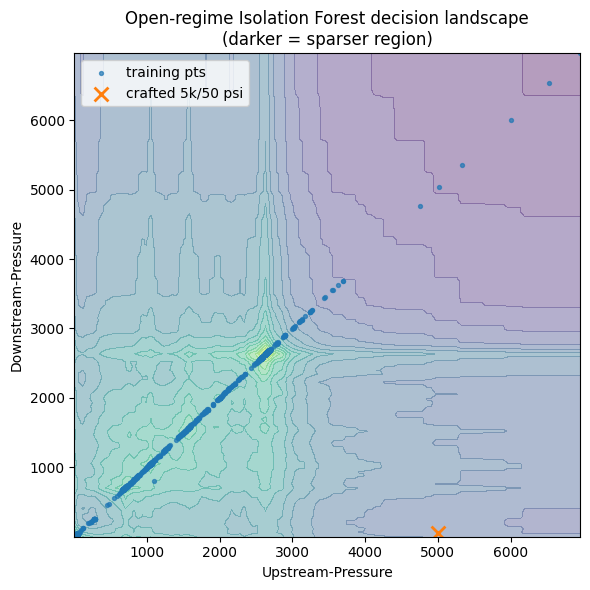

In [ ]:
# --- build a small demo sample from the "open" regime ----------------------
PRESS_FEATS = ["Upstream-Pressure", "Downstream-Pressure"]
open_mask = df_flat["IsOpen"] == 1
sample_df = df_flat.loc[open_mask, PRESS_FEATS].dropna().sample(n=3000, random_state=0)

X = sample_df.values.astype(np.float32)

# fit a tiny Isolation Forest just for visualisation
viz_if = IsolationForest(n_estimators=100, contamination=0.01, random_state=0).fit(X)

scores = viz_if.decision_function(X)  # >0 = inlier, <0 = outlier

# prepare a grid for background score heat‑map
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 120),
                     np.linspace(y_min, y_max, 120))
grid_scores = viz_if.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- plot ------------------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, grid_scores, levels=20, alpha=0.4)         # background density
plt.scatter(X[:,0], X[:,1], s=8, alpha=0.7, label="training pts")
plt.scatter([5000], [50], marker="x", s=100, linewidths=2, label="crafted 5k/50 psi")
plt.xlabel("Upstream‑Pressure")
plt.ylabel("Downstream‑Pressure")
plt.title("Open‑regime Isolation Forest decision landscape\n(darker = sparser region)")
plt.legend()
plt.tight_layout()



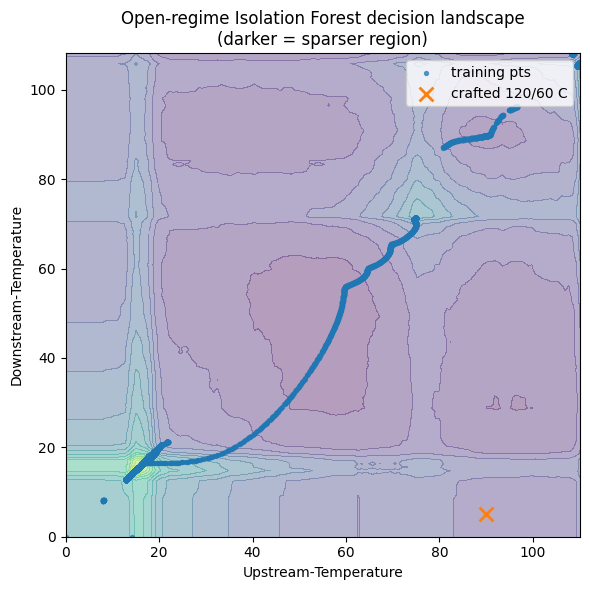

In [ ]:
temp_feats = ["Upstream-Temperature", "Downstream-Temperature"]
open_mask = df_flat["IsOpen"] == 1
sample_df = df_flat.loc[open_mask, temp_feats].dropna().sample(n=100000, random_state=0)

X = sample_df.values.astype(np.float32)

viz_if = IsolationForest(n_estimators=300, contamination=0.01, random_state=0).fit(X)

scores = viz_if.decision_function(X)  # >0 = inlier, <0 = outlier

x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 140),
                     np.linspace(y_min, y_max, 140))
grid_scores = viz_if.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)


plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, grid_scores, levels=20, alpha=0.4)         # background density
plt.scatter(X[:,0], X[:,1], s=8, alpha=0.7, label="training pts")
plt.scatter([90], [5], marker="x", s=100, linewidths=2, label="crafted 120/60 C")
plt.xlabel("Upstream‑Temperature")
plt.ylabel("Downstream‑Temperature")
plt.title("Open‑regime Isolation Forest decision landscape\n(darker = sparser region)")
plt.legend()
plt.tight_layout()

In [21]:
# Step 6 - Residual Models
base_feats = ["Upstream-Pressure", "Downstream-Pressure","Upstream-Temperature", "Downstream-Temperature","Choke-Position","Downstream-Upstream-Difference", "Battery-Voltage"]

targets= {
    'Battery-Voltage': 'residual_battery.onnx',
    'Upstream-Pressure': 'residual_upP.onnx',
    'Downstream-Pressure': 'residual_downP.onnx',
    'Upstream-Temperature': 'residual_upT.onnx',
    'Downstream-Temperature': 'residual_downT.onnx',
 }
mad_mult=4
mad_dict = {}

full_cols  = base_feats + list(targets.keys())
train_df   = df_flat[full_cols].dropna()
train_df   = train_df.loc[:, ~train_df.columns.duplicated()]
print("Training rows :", f"{len(train_df):,}")
print("Unique cols   :", train_df.shape[1])

def save_with_metadata(model, feats, out_path, target):
    onnx_m = onnxmltools.convert_xgboost(
        model,
        name          = target,
        initial_types = [("input", FloatTensorType([None, len(feats)]))],
        target_opset  = 12,
    )
    # embed the feature list so .NET can read it later
    props = onnx_m.metadata_props.add()
    props.key, props.value = "feature_names", ",".join(feats)
    with open(out_path, "wb") as f:
        f.write(onnx_m.SerializeToString())

for target, onnx_name in targets.items():
  feats = [f for f in base_feats if f != target]
  X     = train_df[feats].astype(np.float32).values
  y     = train_df[target].astype(np.float32).values

  model = XGBRegressor(n_estimators =200, max_depth=4, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9,tree_method='hist',random_state=42)
  model.fit(X,y)
  onnx_path = models_dir / onnx_name
  save_with_metadata(model, feats, onnx_path, target)
  print(f"✔ {onnx_name:<20}  [{', '.join(feats)}]")

  resid   = np.abs(y - model.predict(X))
  mad     = np.median(np.abs(resid - np.median(resid)))
  mad_dict[target] = {"mad": float(mad), "cutoff": float(mad_mult * mad)}

mad_path = models_dir / 'residual_mad.json'
with open(mad_path, 'w') as f:
  json.dump(mad_dict,f, indent=2)
print(f"\n residual MADs written to {mad_path.resolve()}")



Training rows : 132,081
Unique cols   : 7
✔ residual_battery.onnx  [Upstream-Pressure, Downstream-Pressure, Upstream-Temperature, Downstream-Temperature, Choke-Position, Downstream-Upstream-Difference]
✔ residual_upP.onnx     [Downstream-Pressure, Upstream-Temperature, Downstream-Temperature, Choke-Position, Downstream-Upstream-Difference, Battery-Voltage]
✔ residual_downP.onnx   [Upstream-Pressure, Upstream-Temperature, Downstream-Temperature, Choke-Position, Downstream-Upstream-Difference, Battery-Voltage]
✔ residual_upT.onnx     [Upstream-Pressure, Downstream-Pressure, Downstream-Temperature, Choke-Position, Downstream-Upstream-Difference, Battery-Voltage]
✔ residual_downT.onnx   [Upstream-Pressure, Downstream-Pressure, Upstream-Temperature, Choke-Position, Downstream-Upstream-Difference, Battery-Voltage]

 residual MADs written to /content/wwwroot/models/residual_mad.json


In [16]:
#Step 7- 7D IF
full_features = ["Battery-Voltage","Upstream-Pressure", "Downstream-Pressure","Upstream-Temperature", "Downstream-Temperature","Choke-Position", "Downstream-Upstream-Difference"]

onnx_full= models_dir/ 'full_vectors_if.onnx'

X7= df_flat[full_features].dropna().astype(np.float32).values

full_if= IsolationForest(n_estimators=300, contamination=0.01, max_features=len(full_features), random_state=42).fit(X7)
print(f"7D Model fitted")

onnx_model = convert_sklearn(full_if, initial_types= [('input',FloatTensorType([None,7]))], target_opset ={"": 12, "ai.onnx.ml": 3})

onnx_full.parent.mkdir(parents=True, exist_ok=True)
with open(onnx_full, 'wb') as f:
  f.write(onnx_model.SerializeToString())
print(f"full_if.onnx saved to: {onnx_full.resolve()}")

sess = ort.InferenceSession(onnx_full.as_posix(), providers=['CPUExecutionProvider'])
lbl, sc = sess.run(None, {"input": X7[:5]})
print("Sample labels:", lbl.flatten())
print("Sample scores :", np.round(sc, 4))


7D Model fitted
full_if.onnx saved to: /content/wwwroot/models/full_vectors_if.onnx
Sample labels: [1 1 1 1 1]
Sample scores : [[0.2721]
 [0.2722]
 [0.2722]
 [0.2722]
 [0.2715]]


In [17]:
sess = ort.InferenceSession(
    (models_dir / "full_vectors_if.onnx").as_posix(),
    providers=["CPUExecutionProvider"]
)

bad_point = np.array([[
    10.5,      # Battery-Voltage  (very low vs usual ~14 V)
    7000.0,    # Upstream-Pressure (psi)  top end of spec
    10.0,      # Downstream-Pressure  (psi)  near zero
    120.0,     # Upstream-Temperature (°C)
    20.0,      # Downstream-Temperature (°C)
    99.0,       # Choke-Position (%) fully open
    6990.0
]], dtype=np.float32)            # shape (1, 6) if you kept ΔP implicit
# If you added ΔP as 7th feature, append:  bad_point = np.hstack([bad_point, [[6990.0]]])

# 3.  Run inference
labels, scores = sess.run(None, {"input": bad_point})

print("IsolationForest outputs")
print("  label :", labels.item())      # –1  ⇒ outlier
print("  score :", scores.item())      # negative ⇒ sparse region


IsolationForest outputs
  label : -1
  score : -0.06805408000946045


In [20]:
import json, hashlib, datetime, numpy as np, onnxruntime as ort
from pathlib import Path

def sha(fp):
    h = hashlib.sha256()
    with open(fp, "rb") as f:
        h.update(f.read())
    return h.hexdigest()[:12]

manifest = {"timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds")+"Z",
            "files": {}}

for fp in sorted(Path(models_dir).glob("*.onnx")):
    sess = ort.InferenceSession(fp.as_posix(), providers=["CPUExecutionProvider"])
    n    = sess.get_inputs()[0].shape[1] or 1
    sess.run(None, {"input": np.zeros((1, n), np.float32)})   # smoke test
    manifest["files"][fp.name] = sha(fp)
    print(f"{fp.name:30s} ✔")

# include MAD JSON too
mad_json = Path(models_dir)/"residual_mad.json"
manifest["files"][mad_json.name] = sha(mad_json)

with open(Path(models_dir)/"model_manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

print("\n📄 model_manifest.json written")


choke_position.onnx            ✔
delta_temp_open.onnx           ✔
delta_temp_shut.onnx           ✔
full_vectors_if.onnx           ✔
pressure_pair_open.onnx        ✔
pressure_pair_shut.onnx        ✔
residual_battery.onnx          ✔
residual_downP.onnx            ✔
residual_downT.onnx            ✔
residual_upP.onnx              ✔
residual_upT.onnx              ✔

📄 model_manifest.json written


In [11]:
import onnxruntime as ort, numpy as np, pathlib

for fp in sorted(pathlib.Path(models_dir).glob("*.onnx")):
    sess = ort.InferenceSession(fp.as_posix(), providers=["CPUExecutionProvider"])
    n    = sess.get_inputs()[0].shape[1] or 1
    print(f"{fp.name:30s} expects {n} features", end=" … ")

    try:
        dummy = np.zeros((1, n), dtype=np.float32)
        sess.run(None, {"input": dummy})
        print("✔")
    except Exception as e:
        print("❌", e)
        break          # first failing file identified



residual_battery.onnx          expects 6 features … ❌ [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running TreeEnsembleRegressor node. Name:'TreeEnsembleRegressor' Status Message: /onnxruntime_src/onnxruntime/core/providers/cpu/ml/tree_ensemble_common.h:476 void onnxruntime::ml::detail::TreeEnsembleCommon<InputType, ThresholdType, OutputType>::ComputeAgg(onnxruntime::concurrency::ThreadPool*, const onnxruntime::Tensor*, onnxruntime::Tensor*, onnxruntime::Tensor*, const AGG&) const [with AGG = onnxruntime::ml::detail::TreeAggregatorSum<float, float, float>; InputType = float; ThresholdType = float; OutputType = float] One path in the graph requests feature 9 but input tensor has 6 features.

